# Prepping the DataFrame

In [2]:
thunder_3y = pd.read_csv('../datasets/thunder/tc_3yr_4com.csv')
thunder_2y = pd.read_csv('../datasets/thunder/tc_2yr_4com.csv')
thunder_1y = pd.read_csv('../datasets/thunder/tc_1yr_4com.csv')

In [3]:
bulls_3y = pd.read_csv('../datasets/bulls/bc_3yrs_4com.csv')
bulls_2y = pd.read_csv('../datasets/bulls/bc_2yrs_4com.csv')
bulls_1y = pd.read_csv('../datasets/bulls/bc_1yrs_4com.csv')

In [4]:
thunder_df = pd.concat([thunder_1y,thunder_2y,thunder_3y])

In [5]:
bulls_df = pd.concat([bulls_3y,bulls_2y,bulls_1y])

In [6]:
thunder_df['is_thunder'] = 1
bulls_df['is_thunder'] = 0

In [7]:
combined_df = pd.concat([thunder_df,bulls_df])

In [8]:

combined_df['body+title']=combined_df['body+title'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n\S+','',regex=True)

# Creating the Model

In [9]:
X = combined_df['body+title']
y = combined_df['is_thunder']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

In [37]:
y_train.shape

(14758,)

In [11]:
logreg = LogisticRegression(C=1,n_jobs=-1,penalty='l2',random_state=13)
tvec = TfidfVectorizer(ngram_range=(1,1),max_features=15000,stop_words='english')

In [12]:
X_train_tf =tvec.fit_transform(X_train)
X_test_tf=tvec.transform(X_test)

In [13]:
logreg.fit(X_train_tf,y_train);

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [14]:
logreg.score(X_train_tf,y_train)

0.9550074535844966

In [15]:
logreg.score(X_test_tf,y_test)

0.9217479674796748

# Visualization prep

In [16]:
#Adapted from General Assembly:5.04 lesson-nlp_ii code
X_train_df = pd.DataFrame(X_train_tf.toarray(),columns=tvec.get_feature_names())

In [17]:
#words_and_values=list(zip(list(np.exp(logreg.coef_[0])),tvec.get_feature_names()))
# The above gives the odds 
words_and_values=list(zip(list(logreg.coef_[0]),tvec.get_feature_names()))






In [18]:
words_and_values.sort()

In [19]:
bulls_words=words_and_values[0:10]

In [20]:
thunder_words=words_and_values[-10:]

In [21]:
bulls_words

[(-14.392886678700664, 'bulls'),
 (-6.108053231617353, 'lauri'),
 (-6.030113813312444, 'chicago'),
 (-5.166208661464737, 'jimmy'),
 (-5.0807209664493005, 'wade'),
 (-4.82645935273721, 'lavine'),
 (-4.656812098514539, 'rondo'),
 (-4.6239668881914, 'markkanen'),
 (-4.531233525599421, 'dunn'),
 (-4.384141825974832, 'hoiberg')]

In [22]:
len(words_and_values)

15000

In [23]:
words_and_values[7490:7510]

[(8.555508397669024e-06, 'alvin'),
 (8.555508397669024e-06, 'arson'),
 (8.555508397669024e-06, 'asu'),
 (8.555508397669024e-06, 'backboard'),
 (8.555508397669024e-06, 'backpedaling'),
 (8.555508397669024e-06, 'bandied'),
 (8.555508397669024e-06, 'blitzkriegs'),
 (8.555508397669024e-06, 'blogger'),
 (8.555508397669024e-06, 'chapo'),
 (8.555508397669024e-06, 'cocktail'),
 (8.555508397669024e-06, 'colabro'),
 (8.555508397669024e-06, 'grandest'),
 (8.555508397669024e-06, 'mythic'),
 (8.555508397669024e-06, 'scoff'),
 (8.555508397669024e-06, 'showtime'),
 (8.555508397669024e-06, 'slice'),
 (8.555508397669024e-06, 'slouch'),
 (8.555508397669024e-06, 'spectacle'),
 (8.555508397669024e-06, 'storylines'),
 (8.555508397669024e-06, 'supersonic')]

In [24]:
thunder_coef,thunder_feature = zip(*thunder_words)

In [25]:
bulls_coef,bulls_feature = zip(*bulls_words)

Text(0, 0.5, '"Thunder"\n Subreddit Words')

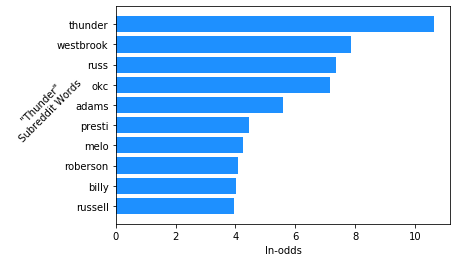

In [26]:
plt.barh(thunder_feature,thunder_coef,color='dodgerblue')
plt.ylim();
plt.xlabel('ln-odds')
plt.ylabel('"Thunder"\n Subreddit Words',rotation=45)

Text(0, 0.5, '"Bulls"\n Subreddit Words')

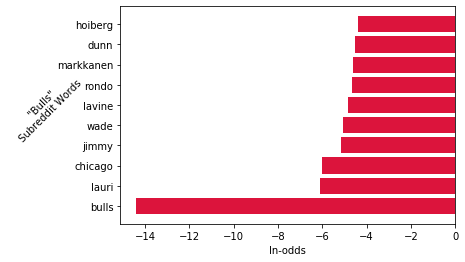

In [27]:
plt.barh(bulls_feature,bulls_coef,color='crimson')
plt.ylim();
plt.xlabel('ln-odds')
plt.ylabel('"Bulls"\n Subreddit Words',rotation=45)

# Metrics

In [28]:
pred = logreg.predict(X_test_tf)

In [29]:
cm=confusion_matrix(y_test,pred)

In [30]:
cm_df=pd.DataFrame(cm,columns=['Pred Bulls',
                        'Pred Thunder'],
            index =['Actual Bulls','Actual Thunder'])

In [31]:
r_cm_df=round(cm_df/10,-1)

In [32]:
r_cm_df.astype(int)

,Pred Bulls,Pred Thunder
Actual Bulls,420,50
Actual Thunder,20,490


In [33]:
Sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
Sensitivity

0.951970201921192

In [34]:
Specificity = cm[0][0]/(cm[0][0]+cm[0][1])
Specificity

0.8892171344165436

In [35]:
predicted_probs=[i[1] for i in logreg.predict_proba(X_test_tf)]

In [36]:
roc_auc_score(y_test,predicted_probs)

0.9780492295760684